In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
#use inspector to see columns names and types for each table
inspector = inspect(engine)

print("Measurement:")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

print("\nStation:")
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
print(recent_date)

('2017-08-23',)


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
oneyearago = dt.date(2017,8,23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= oneyearago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_data_df = pd.DataFrame(year_data, columns=['Date','Precip'])


# Sort the dataframe by date
year_data_df_sorted = year_data_df.sort_values("Date")
year_data_df_sorted.dropna(inplace=True)


yeardf_grouped=year_data_df_sorted.groupby('Date').sum()
yeardf_grouped.head()

,Precip
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


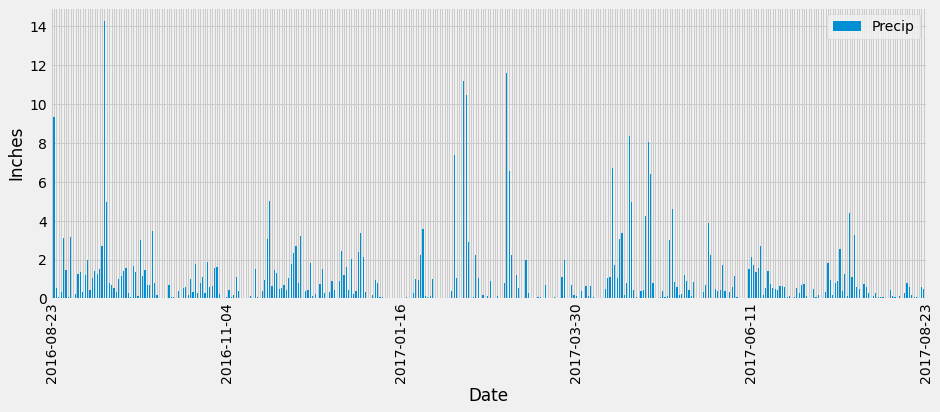

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = yeardf_grouped.plot.bar(figsize=(14,5), grid=True, xlabel='Date', ylabel='Inches', rot=90)

for i, t in enumerate(ax.get_xticklabels()):
    if (i % 73) != 0: #only show xtick labels for the positions divisible by 73
        t.set_visible(False)

plt.savefig('Output/year_precip.png')

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_data_df.describe()

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
#alternative version: session.query(Measurement.station).group_by(Measurement.station).count()
print(total_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.prcp)).\
        group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

#save as dataframe for easier to read display
station_activity_df = pd.DataFrame(station_activity, columns=['Station','Count'])

print(station_activity_df)

       Station  Count
0  USC00519281   2772
1  USC00513117   2696
2  USC00519397   2685
3  USC00519523   2572
4  USC00516128   2484
5  USC00514830   1937
6  USC00511918   1932
7  USC00517948    683
8  USC00518838    342


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
busy_station=station_activity_df.iloc[0,0]

low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == busy_station).first()

high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == busy_station).first()

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == busy_station).first()

print(f'Low temp: {low_temp}\nHigh temp: {high_temp}\nAvg temp: {avg_temp}')

# in one query:
# session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
#     filter(Measurement.station == busy_station).first()

Low temp: (54.0,)
High temp: (85.0,)
Avg temp: (71.66378066378067,)


In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).filter(Measurement.station == busy_station).\
    filter(Measurement.date >= oneyearago).group_by(Measurement.date).all()

In [18]:
#save query result as dataframe for plotting
temp_data_df = pd.DataFrame(temp_data, columns=['Temps'])

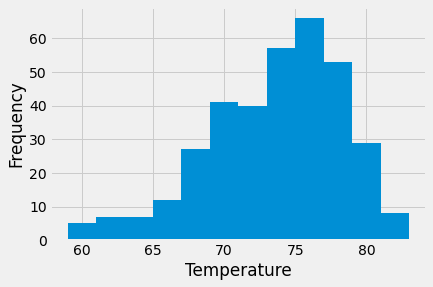

In [22]:
#plot histogram
plt.hist(temp_data_df, 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.savefig('Output/temp_histogram.png')

# Close session

In [20]:
# Close Session
session.close()